<a href="https://colab.research.google.com/github/donbcolab/composable_vlms/blob/main/notebooks/finetuned_object_detection_using_adapters_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuned Object Detection - using vision model adapters

### set up the environment

In [1]:
pip install -Uq setuptools wheel pip

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install -Uq transformers peft torch

In [3]:
!pip install -q einops flash_attn timm

In [4]:
    !pip install -Uq jupyter ipywidgets

In [5]:
import requests
import torch

from PIL import Image
from transformers import AutoProcessor, AutoModelForCausalLM

device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

In [27]:
### some helper functions

In [6]:
import requests
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import io
import numpy as np
import random

# Define a list of colors for variety in bounding box and label colors
colormap = ['blue', 'orange', 'green', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'red',
            'lime', 'indigo', 'violet', 'aqua', 'magenta', 'coral', 'gold', 'tan', 'skyblue']

def download_image(url):
    response = requests.get(url)
    return Image.open(io.BytesIO(response.content))

def plot_bbox(image, data):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.imshow(image)
    for bbox, label in zip(data['bboxes'], data['labels']):
        x1, y1, x2, y2 = bbox
        color = random.choice(colormap)
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        
        # Match label background color to bounding box color
        plt.text(x1, y1 - 5, label, color='white', fontsize=10, fontweight='bold',
                 bbox=dict(facecolor=color, edgecolor='none', alpha=0.7))
    
    ax.axis('off')
    return fig

def display_image_with_boxes(image_url, parsed_answer):
    # Download the image
    image = download_image(image_url)
    
    # Create figure with bounding boxes and labels
    fig = plot_bbox(image, parsed_answer['<OD>'])
    
    # Display the image
    plt.show()
    
    # Close the figure to free up memory
    plt.close(fig)

## Start with a Small Vision Model - with Fine-Tuning capabilities

In [7]:
from transformers import AutoModelForCausalLM, AutoTokenizer

base_vision_model_id = "microsoft/Florence-2-large-ft"

### Set the model for Object Detection mode

In [8]:
hardcoded_od_prompt = "<OD>"

## Patient Blood Sample Biopsy

In [9]:
src_image_url = "https://huggingface.co/spaces/dwb2023/omniscience/resolve/main/examples/BloodImage_00099_jpg.rf.0a65e56401cdd71253e7bc04917c3558.jpg"
src_image = Image.open(requests.get(src_image_url, stream=True).raw)

### Setup and validate the Base Model

In [10]:
model = AutoModelForCausalLM.from_pretrained(base_vision_model_id, torch_dtype=torch_dtype, trust_remote_code=True).to(device)

processor = AutoProcessor.from_pretrained(base_vision_model_id, trust_remote_code=True)

In [11]:
inputs = processor(text=hardcoded_od_prompt, images=src_image, return_tensors="pt").to(device, torch_dtype)

generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    do_sample=False,
    num_beams=3
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

print(f"generated_text: {generated_text}")

generated_text: </s><s>jellyfish<loc_0><loc_0><loc_998><loc_998></s>


In [12]:
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

print(f"generated_text: {generated_text}")

parsed_answer = processor.post_process_generation(generated_text, task="<OD>", image_size=(src_image.width, src_image.height))

print(f"\n\nparsed_answer: {parsed_answer}")

generated_text: </s><s>jellyfish<loc_0><loc_0><loc_998><loc_998></s>


parsed_answer: {'<OD>': {'bboxes': [[0.3199999928474426, 0.23999999463558197, 639.0399780273438, 479.2799987792969]], 'labels': ['jellyfish']}}


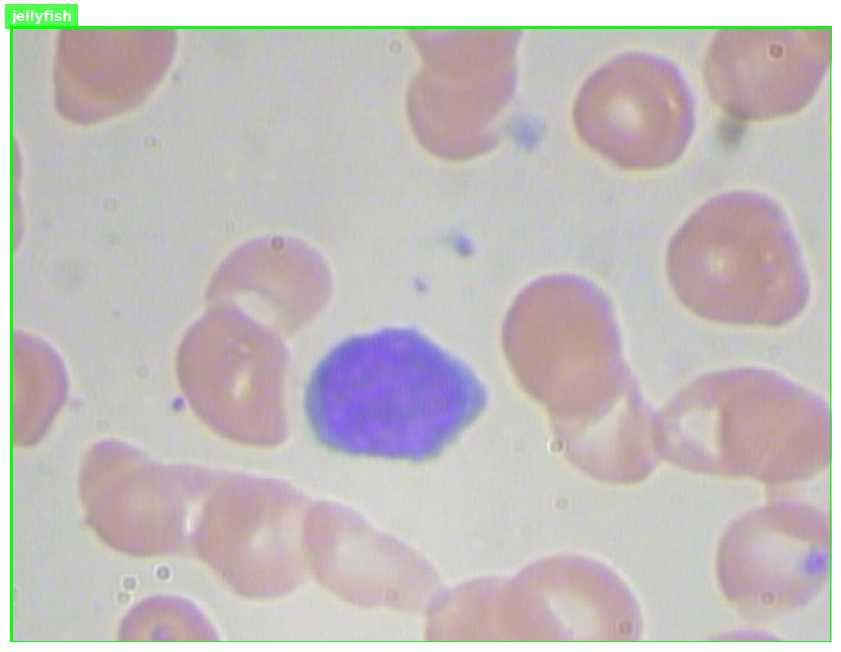

In [13]:
display_image_with_boxes(src_image_url, parsed_answer)

### add the fine-tuned blood biopsy adapter

In [14]:
blood_cell_adapter = "dwb2023/florence2-large-bccd-base-ft"

model.load_adapter(blood_cell_adapter)

In [15]:
inputs = processor(text=hardcoded_od_prompt, images=src_image, return_tensors="pt").to(device, torch_dtype)

generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    do_sample=False,
    num_beams=3
)

In [16]:
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

print(f"generated_text: {generated_text}")

parsed_answer = processor.post_process_generation(generated_text, task="<OD>", image_size=(src_image.width, src_image.height))

print(f"\n\nparsed_answer: {parsed_answer}")

generated_text: </s><s>RBC<loc_792><loc_258><loc_981><loc_492>RBC<loc_588><loc_394><loc_750><loc_633>RBC<loc_677><loc_31><loc_838><loc_238>RBC<loc_198><loc_448><loc_348><loc_688>RBC<loc_231><loc_327><loc_398><loc_506>RBC<loc_848><loc_758><loc_999><loc_969>RBC<loc_598><loc_848><loc_773><loc_999>RBC<loc_2><loc_483><loc_75><loc_685>RBC<loc_73><loc_656><loc_181><loc_819>RBC<loc_217><loc_723><loc_373><loc_931>RBC<loc_475><loc_58><loc_617><loc_223>RBC<loc_834><loc_2><loc_999><loc_158>RBC<loc_44><loc_2><loc_208><loc_169>RBC<loc_494><loc_884><loc_688><loc_999>R<pad><pad><pad>Plate<pad><pad>BC<pad><pad>lets<pad><pad>ate<pad>Pl<pad><pad><loc_2><loc_2><pad><pad><s>Platelets<loc_531><loc_327><loc_569><loc_377></s>


parsed_answer: {'<OD>': {'bboxes': [[507.1999816894531, 124.07999420166016, 628.1599731445312, 236.39999389648438], [376.6399841308594, 189.36000061035156, 480.3199768066406, 304.0799865722656], [433.5999755859375, 15.119999885559082, 536.6400146484375, 114.47999572753906], [127.040000

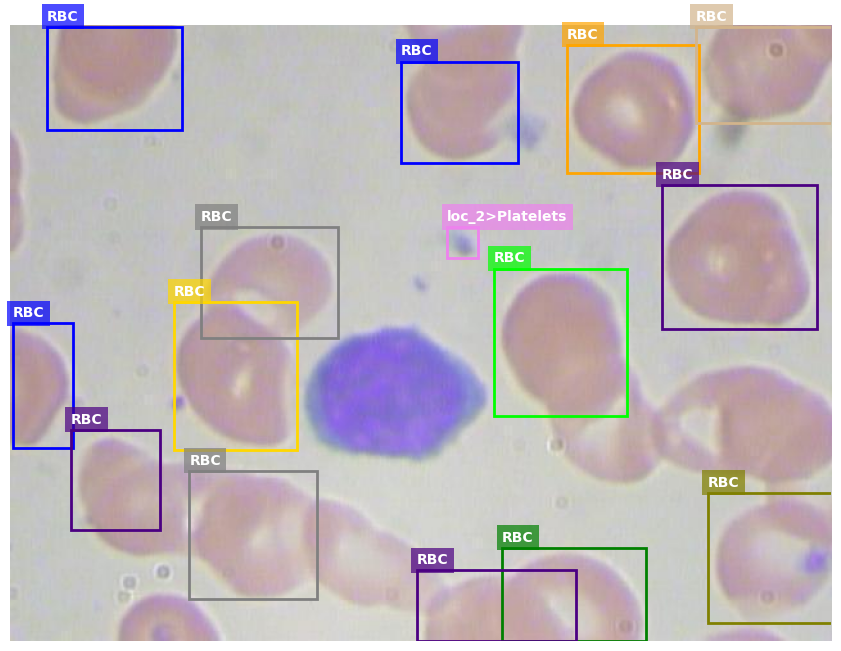

In [17]:
display_image_with_boxes(src_image_url, parsed_answer)

## Patient Liver Sample Biopsy

In [18]:
src_image_url = "https://huggingface.co/spaces/dwb2023/omniscience/resolve/main/examples/15_242_212_25_25_jpg.rf.f6bbadf4260dd2c1f5b4ace1b09b0a1b.jpg"
src_image = Image.open(requests.get(src_image_url, stream=True).raw)

### Set up and validate the Base Model

In [19]:
model = AutoModelForCausalLM.from_pretrained(base_vision_model_id, torch_dtype=torch_dtype, trust_remote_code=True).to(device)

processor = AutoProcessor.from_pretrained(base_vision_model_id, trust_remote_code=True)

In [20]:
inputs = processor(text=hardcoded_od_prompt, images=src_image, return_tensors="pt").to(device, torch_dtype)

generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    do_sample=False,
    num_beams=3
)

In [21]:
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

print(f"generated_text: {generated_text}")

parsed_answer = processor.post_process_generation(generated_text, task="<OD>", image_size=(src_image.width, src_image.height))

print(f"\n\nparsed_answer: {parsed_answer}")

generated_text: </s><s>flower<loc_0><loc_0><loc_998><loc_998></s>


parsed_answer: {'<OD>': {'bboxes': [[0.14949999749660492, 0.14949999749660492, 298.5514831542969, 298.5514831542969]], 'labels': ['flower']}}


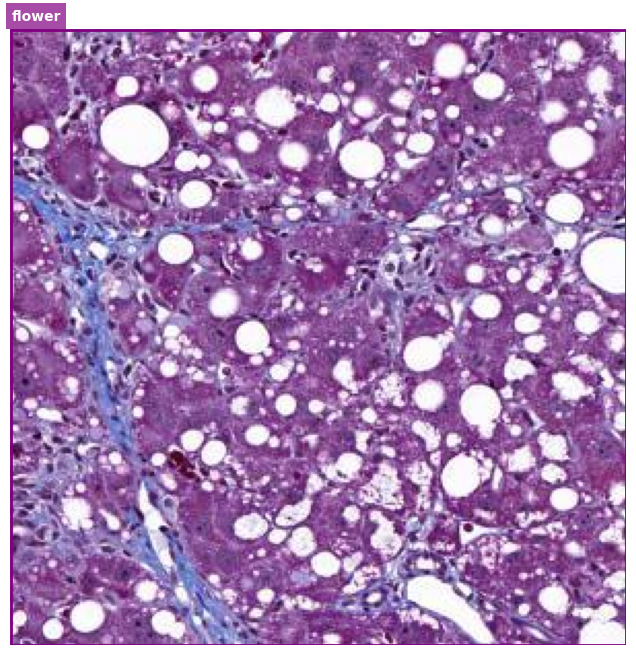

In [22]:
display_image_with_boxes(src_image_url, parsed_answer)

### add the fine-tuned liver biopsy adapter

In [23]:
liver_disease_adapter = "dwb2023/florence2-large-liver-disease-ft"

model.load_adapter(liver_disease_adapter)

In [24]:
inputs = processor(text=hardcoded_od_prompt, images=src_image, return_tensors="pt").to(device, torch_dtype)

generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    do_sample=False,
    num_beams=3
)

In [25]:
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

print(f"generated_text: {generated_text}")

parsed_answer = processor.post_process_generation(generated_text, task="<OD>", image_size=(src_image.width, src_image.height))

print(f"\n\nparsed_answer: {parsed_answer}")

generated_text: </s><s><s>fibrosis<loc_0><loc_231><loc_231><loc_575>fib<pad><pad><pad>inflammation<pad><pad>rosis<pad>inflamm<pad><pad>osis<pad><pad>eat<pad><pad>oon<pad><pad><s></s>


parsed_answer: {'<OD>': {'bboxes': [[0.14949999749660492, 69.21849822998047, 69.21849822998047, 172.07449340820312]], 'labels': ['fibrosis']}}


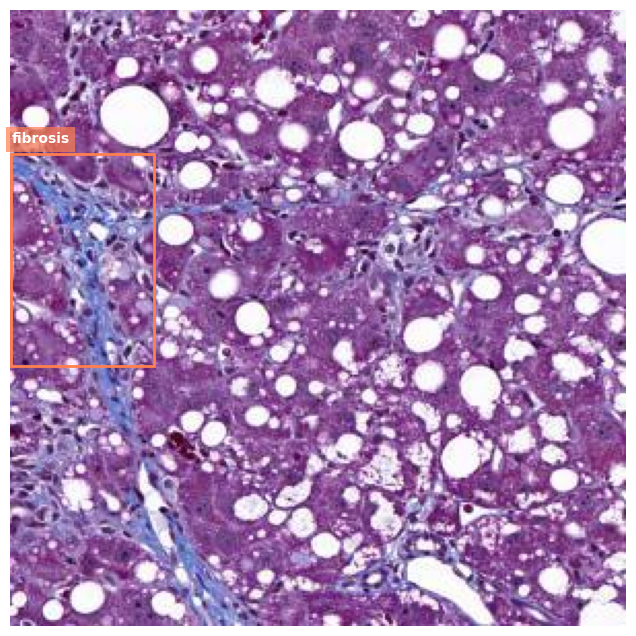

In [26]:
display_image_with_boxes(src_image_url, parsed_answer)